This notebook gathers experiments on 2 layer networks architecture: two full layers of 3 3x3 kernels, with some quantization of the intermediate results. 
1.   Without quantisation, testing accuracy of 97.6%.
2.   With 4 bits quantisation, testing accuracy of 97.0%
3.   With 3 bits quantisation, testing accuracy of 94.9% when fully trained on its own, 96.9% when re-using the 4 bits convolution kernels and retraining the fully connected layers only.



In [0]:
EPOCHS = 50
BATCH_SIZE = 100
LR = 0.001

#0. Import Data / Utils functions

In [0]:
%matplotlib inline
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()

# Simulate an input binarization
x_train = np.minimum(x_train, 100) // 100 * 120
x_test = np.minimum(x_test, 100) // 100 * 120

11493376/11490434 [==============================] - 0s 0us/step


# 1. No quantisation: 97.6%

## 1.1 Network definition

In [0]:
# Sigmoids, whose steepness and bias can be adjusted
# A very steep sigmoid (high bin_rate) simulates a binarization
MAX_BIN_RATE = 50
def binarize_tensor_differentiable(input, thresh, bin_rate):
  out1 = tf.nn.sigmoid(bin_rate*(input[...,:1] - thresh[0]))
  out2 = tf.nn.sigmoid(bin_rate*(input[...,1:2] - thresh[1]))
  out3 = tf.nn.sigmoid(bin_rate*(input[...,2:3] - thresh[2]))
  return tf.concat([out1, out2, out3], axis=-1)

In [0]:
def custom_pooling(conv_bin):
  sum1 = tf.reduce_sum(conv_bin[:,5:14,0:9,:], axis=[1,2])
  sum2 = tf.reduce_sum(conv_bin[:,14:23,0:9,:], axis=[1,2])
  sum3 = tf.reduce_sum(conv_bin[:,0:9,5:14,:], axis=[1,2])
  sum4 = tf.reduce_sum(conv_bin[:,5:14,5:14,:], axis=[1,2])
  sum5 = tf.reduce_sum(conv_bin[:,14:23,5:14,:], axis=[1,2])
  sum6 = tf.reduce_sum(conv_bin[:,19:28,5:14,:], axis=[1,2])
  sum7 = tf.reduce_sum(conv_bin[:,0:9,14:23,:], axis=[1,2])
  sum8 = tf.reduce_sum(conv_bin[:,5:14,14:23,:], axis=[1,2])
  sum9 = tf.reduce_sum(conv_bin[:,14:23,14:23,:], axis=[1,2])
  sum10 = tf.reduce_sum(conv_bin[:,19:28,14:23,:], axis=[1,2])
  sum11 = tf.reduce_sum(conv_bin[:,5:14,19:28,:], axis=[1,2])
  sum12 = tf.reduce_sum(conv_bin[:,14:23,19:28,:], axis=[1,2])
  
  pool = tf.concat([sum1, sum2, sum3, sum4, sum5, sum6, 
                       sum7, sum8, sum9, sum10, sum11, sum12], axis=1)
  
  return pool

In [0]:
def network1(input, thresh, bin_rate_ph):
  # First Convolution
  conv = slim.conv2d(input, 3, [3, 3], rate=1, activation_fn=tf.nn.relu,
                     padding='SAME', scope='conv1')
  
  # Second Convolution
  conv2 = slim.conv2d(conv, 3, [3, 3], rate=1,
                        activation_fn=None, biases_initializer=None,
                        padding='SAME', scope='conv2')
  
  
  # Sigmoid as output binarisation
  # Thresholds act as bias here
  conv2 = binarize_tensor_differentiable(conv2, thresh, bin_rate_ph)
  
  # Sum pooling
  pool = custom_pooling(conv2)
  
  # Flatten + dense
  flat = tf.layers.flatten(pool)
  dense = tf.layers.dense(flat, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(dense, 10, name='dense2')
  
  return out

In [0]:
## Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
bin_rate_ph = tf.placeholder(tf.float32, ())
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([3]), name='out_thresholds')

out_label_op = network1(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
#[n.name for n in tf.get_default_graph().as_graph_def().node]

In [0]:
with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')
  b1 = tf.get_variable('biases')
with tf.variable_scope('conv2', reuse=True) as scope_conv:
  w2 = tf.get_variable('weights')

In [0]:
# Define regularizers
ROUNDING_STEP_CONV = 0.25
ROUNDING_STEP_BIAS = 1.
REG_CONSTANT = 25.

In [0]:
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

In [0]:
NUM_PARAM_REG = 30. + 27. + 27. + 27. + 3.
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerConv(w1))
reg_losses += 3./NUM_PARAM_REG *tf.reduce_mean(customRegularizerBias(b1))
reg_losses += 27./NUM_PARAM_REG*tf.reduce_mean(customRegularizerConv(w2))
reg_losses += 3./NUM_PARAM_REG*tf.reduce_mean(customRegularizerBias(thresh))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op)
sess.run(tf.variables_initializer(opt.variables()))

## 1.2 Training: 97.59%

Evolving params:
- lr_ph : learning rate
- reg_factor_ph : regularization factor -> this time, set directly to final value in the second learning stage
- bin_rate_ph : binarization rate -> this time, set directly to final value in the third learning stage

In [0]:
INPUT_SCALING = 0.7 # So that intermediate values stay in the -127, +127 range

In [0]:
def test_accuracy_bin_rate(bin_rate_feed):
  accs = np.zeros(x_test.shape[0] // BATCH_SIZE)
  for i in range(x_test.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    
    xs = np.expand_dims(x_test[start:stop],-1) * INPUT_SCALING
    ys = y_test[start:stop]
    
    current_acc = sess.run(acc_op,
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed})
    accs[i] = current_acc
  
  print('Testing Acc.: {}'.format(
        accs.mean()))

In [0]:
# Initial version, reg then bin
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    #reg_factor_feed = adaptative_factor(epoch - EPOCHS * 4, EPOCHS * 4)
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = 1.
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    #bin_rate_feed = adaptative_factor(epoch - EPOCHS * 8, EPOCHS * 4)
    bin_rate_feed = MAX_BIN_RATE + 1
    
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1

In [0]:
# Initial version, reg then bin
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    #reg_factor_feed = adaptative_factor(epoch - EPOCHS * 4, EPOCHS * 4)
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = 1.
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    #bin_rate_feed = adaptative_factor(epoch - EPOCHS * 8, EPOCHS * 4)
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1) * INPUT_SCALING
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

Epoch 1 completed, average training loss is 1.7334648538629214
Testing Acc.: 0.7845999985933304
Epoch 2 completed, average training loss is 0.5435956929872433
Testing Acc.: 0.8663000005483628
Epoch 3 completed, average training loss is 0.3844096157451471
Testing Acc.: 0.902500001192093
Epoch 4 completed, average training loss is 0.3174646234760682
Testing Acc.: 0.9223000049591065
Epoch 5 completed, average training loss is 0.27289525032043455
Testing Acc.: 0.9250000017881393
Epoch 6 completed, average training loss is 0.24903189885119598
Testing Acc.: 0.9339000028371811
Epoch 7 completed, average training loss is 0.22191264590869347
Testing Acc.: 0.936400004029274
Epoch 8 completed, average training loss is 0.2013370345843335
Testing Acc.: 0.9428000026941299
Epoch 9 completed, average training loss is 0.1876854702581962
Testing Acc.: 0.9503000062704087
Epoch 10 completed, average training loss is 0.17077568740583957
Testing Acc.: 0.9519000071287155
Epoch 11 completed, average training 

In [0]:
# ^^^^ Above reads:
### Epoch 600 completed, average training loss is 0.061477489174188424
### Testing Acc.: 0.9759000062942504


# Save model, for not having to fully retrain it each time.
saver = tf.train.Saver()
saver.save(sess, 'unquantised/model.ckpt')


'unquantised/model.ckpt'

In [0]:
test_accuracy_bin_rate(MAX_BIN_RATE + 1)

Testing Acc.: 0.9759000062942504


In [0]:
!zip -r unquantised.zip unquantised

  adding: unquantised/ (stored 0%)
  adding: unquantised/model.ckpt.data-00000-of-00001 (deflated 33%)
  adding: unquantised/model.ckpt.index (deflated 43%)
  adding: unquantised/checkpoint (deflated 42%)
  adding: unquantised/model.ckpt.meta (deflated 88%)


## 1.3 Weights rounding: 97.46%

In [0]:
!unzip unquantised.zip

Archive:  unquantised.zip
replace unquantised/model.ckpt.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
# Sigmoids, whose steepness and bias can be adjusted
# A very steep sigmoid (high bin_rate) simulates a binarization
MAX_BIN_RATE = 50
def binarize_tensor_differentiable(input, thresh, bin_rate):
  out1 = tf.nn.sigmoid(bin_rate*(input[...,:1] - thresh[0]))
  out2 = tf.nn.sigmoid(bin_rate*(input[...,1:2] - thresh[1]))
  out3 = tf.nn.sigmoid(bin_rate*(input[...,2:3] - thresh[2]))
  return tf.concat([out1, out2, out3], axis=-1)

def custom_pooling(conv_bin):
  sum1 = tf.reduce_sum(conv_bin[:,5:14,0:9,:], axis=[1,2])
  sum2 = tf.reduce_sum(conv_bin[:,14:23,0:9,:], axis=[1,2])
  sum3 = tf.reduce_sum(conv_bin[:,0:9,5:14,:], axis=[1,2])
  sum4 = tf.reduce_sum(conv_bin[:,5:14,5:14,:], axis=[1,2])
  sum5 = tf.reduce_sum(conv_bin[:,14:23,5:14,:], axis=[1,2])
  sum6 = tf.reduce_sum(conv_bin[:,19:28,5:14,:], axis=[1,2])
  sum7 = tf.reduce_sum(conv_bin[:,0:9,14:23,:], axis=[1,2])
  sum8 = tf.reduce_sum(conv_bin[:,5:14,14:23,:], axis=[1,2])
  sum9 = tf.reduce_sum(conv_bin[:,14:23,14:23,:], axis=[1,2])
  sum10 = tf.reduce_sum(conv_bin[:,19:28,14:23,:], axis=[1,2])
  sum11 = tf.reduce_sum(conv_bin[:,5:14,19:28,:], axis=[1,2])
  sum12 = tf.reduce_sum(conv_bin[:,14:23,19:28,:], axis=[1,2])
  
  pool = tf.concat([sum1, sum2, sum3, sum4, sum5, sum6, 
                       sum7, sum8, sum9, sum10, sum11, sum12], axis=1)
  
  return pool

def network1(input, thresh, bin_rate_ph):
  # First Convolution
  conv = slim.conv2d(input, 3, [3, 3], rate=1, activation_fn=tf.nn.relu,
                     padding='SAME', scope='conv1')
  
  # Second Convolution
  conv2 = slim.conv2d(conv, 3, [3, 3], rate=1,
                        activation_fn=None, biases_initializer=None,
                        padding='SAME', scope='conv2')
  
  
  # Sigmoid as output binarisation
  # Thresholds act as bias here
  conv2 = binarize_tensor_differentiable(conv2, thresh, bin_rate_ph)
  
  # Sum pooling
  pool = custom_pooling(conv2)
  
  # Flatten + dense
  flat = tf.layers.flatten(pool)
  dense = tf.layers.dense(flat, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(dense, 10, name='dense2')
  
  return out

## Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
bin_rate_ph = tf.placeholder(tf.float32, ())
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([3]), name='out_thresholds')

out_label_op = network1(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('unquantised')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate(MAX_BIN_RATE)

W0831 16:21:09.277668 140007541606272 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Testing Acc.: 0.9759000062942504


In [0]:
with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')
  b1 = tf.get_variable('biases')
with tf.variable_scope('conv2', reuse=True) as scope_conv:
  w2 = tf.get_variable('weights')

In [0]:
# Define regularizers
ROUNDING_STEP_CONV = 0.25
ROUNDING_STEP_BIAS = 1.
REG_CONSTANT = 4.

Testing Acc.: 0.9746000081300735


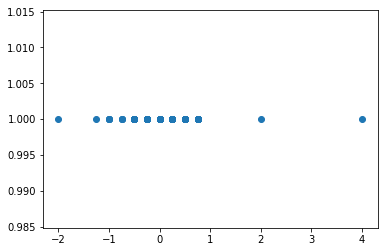

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_bias1_op = tf.assign(b1,
                          tf.round(b1/ROUNDING_STEP_BIAS)*ROUNDING_STEP_BIAS)
rounding_weights2_op = tf.assign(w2, 
                          tf.round(w2/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_thresh_op = tf.assign(thresh,
                          tf.round(thresh/ROUNDING_STEP_BIAS)*ROUNDING_STEP_BIAS)
_ = sess.run([rounding_weights1_op, rounding_bias1_op])
_ = sess.run([rounding_weights2_op, rounding_thresh_op])


# Show final distribution of weights
w1_values, b1_values = sess.run([w1, b1])
w2_values, thresh_values = sess.run([w2, thresh])

kernel_values = (list(w1_values.flatten()) + list(b1_values.flatten())
                 + list(w2_values.flatten())
                 + list(thresh_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))

test_accuracy_bin_rate(MAX_BIN_RATE)

## 1.4 Retrain FC: 97.61%

In [0]:
LR = 0.001/4

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

opt_fc = tf.train.AdamOptimizer(learning_rate=LR, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
def test_accuracy_bin_rate(bin_rate_feed):
  accs = np.zeros(x_test.shape[0] // BATCH_SIZE)
  for i in range(x_test.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    
    xs = np.expand_dims(x_test[start:stop],-1) * INPUT_SCALING
    ys = y_test[start:stop]
    
    current_acc = sess.run(acc_op,
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed})
    accs[i] = current_acc
  
  print('Testing Acc.: {}'.format(
        accs.mean()))

In [0]:
bin_rate_feed = MAX_BIN_RATE + 1

for epoch in range(EPOCHS*2):

  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]

    xs = np.expand_dims(x_train[selected],-1) * INPUT_SCALING
    ys = y_train[selected]

    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss

  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

test_accuracy_bin_rate(MAX_BIN_RATE + 1)


Epoch 1 completed, average training loss is 0.06240302110789344
Testing Acc.: 0.9754000061750412
Epoch 2 completed, average training loss is 0.061438791300946226
Testing Acc.: 0.9761000072956085
Epoch 3 completed, average training loss is 0.06187951751402579
Testing Acc.: 0.9757000064849853
Epoch 4 completed, average training loss is 0.06145342868442337
Testing Acc.: 0.9746000057458878
Epoch 5 completed, average training loss is 0.061461475035951785
Testing Acc.: 0.9767000061273575
Epoch 6 completed, average training loss is 0.06135069111168074
Testing Acc.: 0.9769000065326691
Epoch 7 completed, average training loss is 0.061346774341848986
Testing Acc.: 0.9776000076532364
Epoch 8 completed, average training loss is 0.06107683159488564
Testing Acc.: 0.9758000069856644
Epoch 9 completed, average training loss is 0.06124272273077319
Testing Acc.: 0.975300008058548
Epoch 10 completed, average training loss is 0.061452872081814956
Testing Acc.: 0.9768000078201294
Epoch 11 completed, averag

In [0]:
test_accuracy_bin_rate(MAX_BIN_RATE)
test_accuracy_bin_rate(5000)

# 2. 4 bits unsigned quantisation: 97.0%

## 2.1 Network definition

In [0]:
# Quantize a [0, +127] value on 4 bits, so that
# it fits in 4 DREGs
# 4 DREGs for the most significant bits
def quantization_4bits_unsigned(tensor):
  sign = tf.sign(tensor)
  
  cast = tf.cast(sign*tensor, tf.int32)
  sign = tf.cast(sign, tf.int32)
  
  digitized = (64*tf.mod(tf.bitwise.right_shift(cast,6), 2) +
               32*tf.mod(tf.bitwise.right_shift(cast,5), 2) +
               16*tf.mod(tf.bitwise.right_shift(cast,4), 2) + 
               8*tf.mod(tf.bitwise.right_shift(cast,3), 2))
  digitized = digitized * sign  
  return tf.cast(digitized, tf.float32)

In [0]:
# Sigmoids, whose steepness and bias can be adjusted
# A very steep sigmoid (high bin_rate) simulates a binarization
MAX_BIN_RATE = 50
def binarize_tensor_differentiable(input, thresh, bin_rate):
  out1 = tf.nn.sigmoid(bin_rate*(input[...,:1] - thresh[0]))
  out2 = tf.nn.sigmoid(bin_rate*(input[...,1:2] - thresh[1]))
  out3 = tf.nn.sigmoid(bin_rate*(input[...,2:3] - thresh[2]))
  return tf.concat([out1, out2, out3], axis=-1)

In [0]:
def custom_pooling(conv_bin):
  sum1 = tf.reduce_sum(conv_bin[:,5:14,0:9,:], axis=[1,2])
  sum2 = tf.reduce_sum(conv_bin[:,14:23,0:9,:], axis=[1,2])
  sum3 = tf.reduce_sum(conv_bin[:,0:9,5:14,:], axis=[1,2])
  sum4 = tf.reduce_sum(conv_bin[:,5:14,5:14,:], axis=[1,2])
  sum5 = tf.reduce_sum(conv_bin[:,14:23,5:14,:], axis=[1,2])
  sum6 = tf.reduce_sum(conv_bin[:,19:28,5:14,:], axis=[1,2])
  sum7 = tf.reduce_sum(conv_bin[:,0:9,14:23,:], axis=[1,2])
  sum8 = tf.reduce_sum(conv_bin[:,5:14,14:23,:], axis=[1,2])
  sum9 = tf.reduce_sum(conv_bin[:,14:23,14:23,:], axis=[1,2])
  sum10 = tf.reduce_sum(conv_bin[:,19:28,14:23,:], axis=[1,2])
  sum11 = tf.reduce_sum(conv_bin[:,5:14,19:28,:], axis=[1,2])
  sum12 = tf.reduce_sum(conv_bin[:,14:23,19:28,:], axis=[1,2])
  
  pool = tf.concat([sum1, sum2, sum3, sum4, sum5, sum6, 
                       sum7, sum8, sum9, sum10, sum11, sum12], axis=1)
  
  return pool

In [0]:
def network2(input, thresh, bin_rate_ph):
  # First Convolution
  conv = slim.conv2d(input, 3, [3, 3], rate=1, activation_fn=tf.nn.relu,
                     padding='SAME', scope='conv1')
  
  # Second Convolution
  # C2.1, none of the input is quantized
  conv2_1 = slim.conv2d(conv, 1, [3, 3], rate=1,
                        activation_fn=None, biases_initializer=None,
                        padding='SAME', scope='conv2.1')
  
  # C2.2, two inputs (out of 3) are quantized
  slice_A_2_2 = quantization_4bits_unsigned(conv[...,:2])
  slice_B_2_2 = conv[...,2:]
  conv2_2_input = tf.concat([slice_A_2_2, slice_B_2_2], axis=-1)
  conv2_2 = slim.conv2d(conv2_2_input, 1, [3, 3], rate=1,
                        activation_fn=None, biases_initializer=None,
                        padding='SAME', scope='conv2.2')
  
  # C2.3, same inputs as for C2.2 (2 feature maps quantified out of 3)
  conv2_3 = slim.conv2d(conv2_2_input, 1, [3, 3], rate=1,
                        activation_fn=None, biases_initializer=None,
                        padding='SAME', scope='conv2.3')
  
  
  conv2 = tf.concat([conv2_1, conv2_2, conv2_3], axis=-1)
  
  # Sigmoid as output binarisation
  # Thresholds act as bias here
  conv2 = binarize_tensor_differentiable(conv2, thresh, bin_rate_ph)
  
  # Sum pooling
  pool = custom_pooling(conv2)
  
  # Flatten + dense
  flat = tf.layers.flatten(pool)
  dense = tf.layers.dense(flat, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(dense, 10, name='dense2')
  
  return out

In [0]:
## Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
bin_rate_ph = tf.placeholder(tf.float32, ())
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([3]), name='out_thresholds')

out_label_op = network2(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
#[n.name for n in tf.get_default_graph().as_graph_def().node]

In [0]:
with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')
  b1 = tf.get_variable('biases')
with tf.variable_scope('conv2.1', reuse=True) as scope_conv:
  w2_1 = tf.get_variable('weights')
with tf.variable_scope('conv2.2', reuse=True) as scope_conv:
  w2_2 = tf.get_variable('weights')
with tf.variable_scope('conv2.3', reuse=True) as scope_conv:
  w2_3 = tf.get_variable('weights')

In [0]:
# Define regularizers
ROUNDING_STEP_CONV = 0.25
ROUNDING_STEP_BIAS = 1.
REG_CONSTANT = 25.

In [0]:
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

In [0]:
NUM_PARAM_REG = 30. + 27. + 27. + 27. + 3.
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerConv(w1))
reg_losses += 3./NUM_PARAM_REG *tf.reduce_mean(customRegularizerBias(b1))
reg_losses += 27./NUM_PARAM_REG*tf.reduce_mean(customRegularizerConv(w2_1))
reg_losses += 27./NUM_PARAM_REG*tf.reduce_mean(customRegularizerConv(w2_2))
reg_losses += 27./NUM_PARAM_REG*tf.reduce_mean(customRegularizerConv(w2_3))
reg_losses += 3./NUM_PARAM_REG*tf.reduce_mean(customRegularizerBias(thresh))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op)
sess.run(tf.variables_initializer(opt.variables()))

## 2.2 Training: 97.1%

Evolving params:
- lr_ph : learning rate
- reg_factor_ph : regularization factor -> this time, set directly to final value in the second learning stage
- bin_rate_ph : binarization rate -> this time, set directly to final value in the third learning stage

In [0]:
INPUT_SCALING = 0.7

In [0]:
def test_accuracy_bin_rate(bin_rate_feed):
  accs = np.zeros(x_test.shape[0] // BATCH_SIZE)
  for i in range(x_test.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    
    xs = np.expand_dims(x_test[start:stop],-1) * INPUT_SCALING
    ys = y_test[start:stop]
    
    current_acc = sess.run(acc_op,
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed})
    accs[i] = current_acc
  
  print('Testing Acc.: {}'.format(
        accs.mean()))

In [0]:
# Initial version, reg then bin
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    #reg_factor_feed = adaptative_factor(epoch - EPOCHS * 4, EPOCHS * 4)
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = 1.
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    #bin_rate_feed = adaptative_factor(epoch - EPOCHS * 8, EPOCHS * 4)
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1) * INPUT_SCALING
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

Epoch 1 completed, average training loss is 4.789047748247782
Testing Acc.: 0.5875999987125397
Epoch 2 completed, average training loss is 0.9418615859250228
Testing Acc.: 0.790499997138977
Epoch 3 completed, average training loss is 0.5781417363882064
Testing Acc.: 0.8586000001430512
Epoch 4 completed, average training loss is 0.42854555959502855
Testing Acc.: 0.877299998998642
Epoch 5 completed, average training loss is 0.3445007232328256
Testing Acc.: 0.9051000010967255
Epoch 6 completed, average training loss is 0.2994749060521523
Testing Acc.: 0.9102000004053116
Epoch 7 completed, average training loss is 0.2665181989967823
Testing Acc.: 0.9136999982595444
Epoch 8 completed, average training loss is 0.2467475297798713
Testing Acc.: 0.9295000052452087
Epoch 9 completed, average training loss is 0.2258262018300593
Testing Acc.: 0.9327000039815903
Epoch 10 completed, average training loss is 0.210019299890846
Testing Acc.: 0.9399000042676926
Epoch 11 completed, average training loss 

In [0]:
# ^^^^ Above reads:
### Epoch 600 completed, average training loss is 0.09010642134274045
### Testing Acc.: 0.9716000092029572


# Save model, for not having to fully retrain it each time.
saver = tf.train.Saver()
saver.save(sess, '4bits/model.ckpt')


'4bits/model.ckpt'

In [0]:
test_accuracy_bin_rate(MAX_BIN_RATE + 1)

Testing Acc.: 0.9716000092029572


In [0]:
!zip -r 4bits.zip 4bits

  adding: 4bits/ (stored 0%)
  adding: 4bits/model.ckpt.data-00000-of-00001 (deflated 37%)
  adding: 4bits/model.ckpt.index (deflated 49%)
  adding: 4bits/checkpoint (deflated 42%)
  adding: 4bits/model.ckpt.meta (deflated 89%)


## 2.3 Weights rounding

In [0]:
!unzip 4bits.zip

In [0]:
# Quantize a [0, +127] value on 4 bits, so that
# it fits in 4 DREGs
# 4 DREGs for the most significant bits
def quantization_4bits_unsigned(tensor):
  sign = tf.sign(tensor)
  
  cast = tf.cast(sign*tensor, tf.int32)
  sign = tf.cast(sign, tf.int32)
  
  digitized = (64*tf.mod(tf.bitwise.right_shift(cast,6), 2) +
               32*tf.mod(tf.bitwise.right_shift(cast,5), 2) +
               16*tf.mod(tf.bitwise.right_shift(cast,4), 2) + 
               8*tf.mod(tf.bitwise.right_shift(cast,3), 2))
  digitized = digitized * sign  
  return tf.cast(digitized, tf.float32)

# Sigmoids, whose steepness and bias can be adjusted
# A very steep sigmoid (high bin_rate) simulates a binarization
MAX_BIN_RATE = 50
def binarize_tensor_differentiable(input, thresh, bin_rate):
  out1 = tf.nn.sigmoid(bin_rate*(input[...,:1] - thresh[0]))
  out2 = tf.nn.sigmoid(bin_rate*(input[...,1:2] - thresh[1]))
  out3 = tf.nn.sigmoid(bin_rate*(input[...,2:3] - thresh[2]))
  return tf.concat([out1, out2, out3], axis=-1)

def custom_pooling(conv_bin):
  sum1 = tf.reduce_sum(conv_bin[:,5:14,0:9,:], axis=[1,2])
  sum2 = tf.reduce_sum(conv_bin[:,14:23,0:9,:], axis=[1,2])
  sum3 = tf.reduce_sum(conv_bin[:,0:9,5:14,:], axis=[1,2])
  sum4 = tf.reduce_sum(conv_bin[:,5:14,5:14,:], axis=[1,2])
  sum5 = tf.reduce_sum(conv_bin[:,14:23,5:14,:], axis=[1,2])
  sum6 = tf.reduce_sum(conv_bin[:,19:28,5:14,:], axis=[1,2])
  sum7 = tf.reduce_sum(conv_bin[:,0:9,14:23,:], axis=[1,2])
  sum8 = tf.reduce_sum(conv_bin[:,5:14,14:23,:], axis=[1,2])
  sum9 = tf.reduce_sum(conv_bin[:,14:23,14:23,:], axis=[1,2])
  sum10 = tf.reduce_sum(conv_bin[:,19:28,14:23,:], axis=[1,2])
  sum11 = tf.reduce_sum(conv_bin[:,5:14,19:28,:], axis=[1,2])
  sum12 = tf.reduce_sum(conv_bin[:,14:23,19:28,:], axis=[1,2])
  
  pool = tf.concat([sum1, sum2, sum3, sum4, sum5, sum6, 
                       sum7, sum8, sum9, sum10, sum11, sum12], axis=1)
  
  return pool

def network2(input, thresh, bin_rate_ph):
  # First Convolution
  conv = slim.conv2d(input, 3, [3, 3], rate=1, activation_fn=tf.nn.relu,
                     padding='SAME', scope='conv1')
  
  # Second Convolution
  # C2.1, none of the input is quantized
  conv2_1 = slim.conv2d(conv, 1, [3, 3], rate=1,
                        activation_fn=None, biases_initializer=None,
                        padding='SAME', scope='conv2.1')
  
  # C2.2, two inputs (out of 3) are quantized
  slice_A_2_2 = quantization_4bits_unsigned(conv[...,:2])
  slice_B_2_2 = conv[...,2:]
  conv2_2_input = tf.concat([slice_A_2_2, slice_B_2_2], axis=-1)
  conv2_2 = slim.conv2d(conv2_2_input, 1, [3, 3], rate=1,
                        activation_fn=None, biases_initializer=None,
                        padding='SAME', scope='conv2.2')
  
  # C2.3, same inputs as for C2.2 (2 feature maps quantified out of 3)
  conv2_3 = slim.conv2d(conv2_2_input, 1, [3, 3], rate=1,
                        activation_fn=None, biases_initializer=None,
                        padding='SAME', scope='conv2.3')
  
  
  conv2 = tf.concat([conv2_1, conv2_2, conv2_3], axis=-1)
  
  # Sigmoid as output binarisation
  # Thresholds act as bias here
  conv2 = binarize_tensor_differentiable(conv2, thresh, bin_rate_ph)
  
  # Sum pooling
  pool = custom_pooling(conv2)
  
  # Flatten + dense
  flat = tf.layers.flatten(pool)
  dense = tf.layers.dense(flat, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(dense, 10, name='dense2')
  
  return out

## Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
bin_rate_ph = tf.placeholder(tf.float32, ())
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([3]), name='out_thresholds')

out_label_op = network2(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('4bits')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate(MAX_BIN_RATE)

W0902 09:02:06.496021 140268826339200 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Testing Acc.: 0.971100007891655


In [0]:
with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')
  b1 = tf.get_variable('biases')
with tf.variable_scope('conv2.1', reuse=True) as scope_conv:
  w2_1 = tf.get_variable('weights')
with tf.variable_scope('conv2.2', reuse=True) as scope_conv:
  w2_2 = tf.get_variable('weights')
with tf.variable_scope('conv2.3', reuse=True) as scope_conv:
  w2_3 = tf.get_variable('weights')

In [0]:
# Define regularizers
ROUNDING_STEP_CONV = 0.25
ROUNDING_STEP_BIAS = 1.
REG_CONSTANT = 4.

Testing Acc.: 0.814500002861023


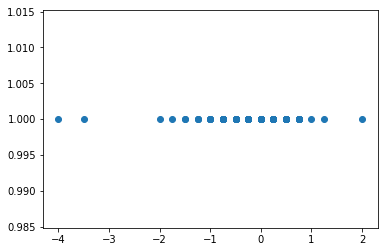

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_bias1_op = tf.assign(b1,
                          tf.round(b1/ROUNDING_STEP_BIAS)*ROUNDING_STEP_BIAS)
rounding_weights2_1_op = tf.assign(w2_1, 
                          tf.round(w2_1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_weights2_2_op = tf.assign(w2_2, 
                          tf.round(w2_2/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_weights2_3_op = tf.assign(w2_3, 
                          tf.round(w2_3/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_thresh_op = tf.assign(thresh,
                          tf.round(thresh/ROUNDING_STEP_BIAS)*ROUNDING_STEP_BIAS)
_ = sess.run([rounding_weights1_op, rounding_bias1_op])
_ = sess.run([rounding_weights2_1_op, rounding_weights2_2_op])
_ = sess.run([rounding_weights2_3_op, rounding_thresh_op])


# Show final distribution of weights
w1_values, b1_values = sess.run([w1, b1])
w2_1_values, w2_2_values = sess.run([w2_1, w2_2])
w2_3_values, thresh_values = sess.run([w2_3, thresh])

kernel_values = (list(w1_values.flatten()) + list(b1_values.flatten())
                 + list(w2_1_values.flatten())
                 + list(w2_2_values.flatten())
                 + list(w2_3_values.flatten())
                 + list(thresh_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))

test_accuracy_bin_rate(MAX_BIN_RATE)

In [0]:
sess.run(w2_1)

## 2.4 Retrain FC

In [0]:
LR = 0.001/4

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

opt_fc = tf.train.AdamOptimizer(learning_rate=LR, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
def test_accuracy_bin_rate(bin_rate_feed):
  accs = np.zeros(x_test.shape[0] // BATCH_SIZE)
  for i in range(x_test.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    
    xs = np.expand_dims(x_test[start:stop],-1) * INPUT_SCALING
    ys = y_test[start:stop]
    
    current_acc = sess.run(acc_op,
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed})
    accs[i] = current_acc
  
  print('Testing Acc.: {}'.format(
        accs.mean()))

In [0]:
bin_rate_feed = MAX_BIN_RATE + 1

for epoch in range(EPOCHS*2):

  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]

    xs = np.expand_dims(x_train[selected],-1) * INPUT_SCALING
    ys = y_train[selected]

    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss

  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

test_accuracy_bin_rate(MAX_BIN_RATE + 1)


Epoch 1 completed, average training loss is 0.12474793142639101
Testing Acc.: 0.9641000056266784
Epoch 2 completed, average training loss is 0.10504382239188999
Testing Acc.: 0.9675000071525574
Epoch 3 completed, average training loss is 0.10201754812461634
Testing Acc.: 0.9663000059127808
Epoch 4 completed, average training loss is 0.09987455175879101
Testing Acc.: 0.9661000025272369
Epoch 5 completed, average training loss is 0.09955287608628471
Testing Acc.: 0.9667000061273575
Epoch 6 completed, average training loss is 0.09854853264987469
Testing Acc.: 0.9670000070333481
Epoch 7 completed, average training loss is 0.09818603516245882
Testing Acc.: 0.9681000047922135
Epoch 8 completed, average training loss is 0.09763067949408044
Testing Acc.: 0.967700006365776
Epoch 9 completed, average training loss is 0.09713823487982154
Testing Acc.: 0.9687000066041946
Epoch 10 completed, average training loss is 0.0965991374043127
Testing Acc.: 0.9687000060081482
Epoch 11 completed, average tra

In [0]:
test_accuracy_bin_rate(MAX_BIN_RATE)
test_accuracy_bin_rate(5000)

In [0]:
# Get final distribution of weights
w1_values, b1_values = sess.run([w1, b1])
w2_1_values, w2_2_values = sess.run([w2_1, w2_2])
w2_3_values, thresh_values = sess.run([w2_3, thresh])

with open('NP_WEIGHTS_4bits.pck', 'wb') as f:
  pickle.dump((w1_values, b1_values, w2_1_values, w2_2_values, w2_3_values, thresh_values), f)

# 3. 3 bits unsigned quantisation: 94.9% with fully independent training, 96.9% when re-using convolutions from the above network

## 3.1 Network definition

In [0]:
# Quantize a [0, +127] value on 3 bits, so that
# it fits in 3 DREGs
# 3 DREGs for the most significant bits
def quantization_3bits_unsigned(tensor):
  sign = tf.sign(tensor)
  
  cast = tf.cast(sign*tensor, tf.int32)
  sign = tf.cast(sign, tf.int32)
  
  digitized = (64*tf.mod(tf.bitwise.right_shift(cast,6), 2) +
               32*tf.mod(tf.bitwise.right_shift(cast,5), 2) +
               16*tf.mod(tf.bitwise.right_shift(cast,4), 2))
  digitized = digitized * sign  
  return tf.cast(digitized, tf.float32)

In [0]:
# Sigmoids, whose steepness and bias can be adjusted
# A very steep sigmoid (high bin_rate) simulates a binarization
MAX_BIN_RATE = 50
def binarize_tensor_differentiable(input, thresh, bin_rate):
  out1 = tf.nn.sigmoid(bin_rate*(input[...,:1] - thresh[0]))
  out2 = tf.nn.sigmoid(bin_rate*(input[...,1:2] - thresh[1]))
  out3 = tf.nn.sigmoid(bin_rate*(input[...,2:3] - thresh[2]))
  return tf.concat([out1, out2, out3], axis=-1)

In [0]:
def custom_pooling(conv_bin):
  sum1 = tf.reduce_sum(conv_bin[:,5:14,0:9,:], axis=[1,2])
  sum2 = tf.reduce_sum(conv_bin[:,14:23,0:9,:], axis=[1,2])
  sum3 = tf.reduce_sum(conv_bin[:,0:9,5:14,:], axis=[1,2])
  sum4 = tf.reduce_sum(conv_bin[:,5:14,5:14,:], axis=[1,2])
  sum5 = tf.reduce_sum(conv_bin[:,14:23,5:14,:], axis=[1,2])
  sum6 = tf.reduce_sum(conv_bin[:,19:28,5:14,:], axis=[1,2])
  sum7 = tf.reduce_sum(conv_bin[:,0:9,14:23,:], axis=[1,2])
  sum8 = tf.reduce_sum(conv_bin[:,5:14,14:23,:], axis=[1,2])
  sum9 = tf.reduce_sum(conv_bin[:,14:23,14:23,:], axis=[1,2])
  sum10 = tf.reduce_sum(conv_bin[:,19:28,14:23,:], axis=[1,2])
  sum11 = tf.reduce_sum(conv_bin[:,5:14,19:28,:], axis=[1,2])
  sum12 = tf.reduce_sum(conv_bin[:,14:23,19:28,:], axis=[1,2])
  
  pool = tf.concat([sum1, sum2, sum3, sum4, sum5, sum6, 
                       sum7, sum8, sum9, sum10, sum11, sum12], axis=1)
  
  return pool

In [0]:
def network3(input, thresh, bin_rate_ph):
  # First Convolution
  conv = slim.conv2d(input, 3, [3, 3], rate=1, activation_fn=tf.nn.relu,
                     padding='SAME', scope='conv1')
  
  # Second Convolution
  # C2.1, none of the input is quantized
  conv2_1 = slim.conv2d(conv, 1, [3, 3], rate=1,
                        activation_fn=None, biases_initializer=None,
                        padding='SAME', scope='conv2.1')
  
  # C2.2, two inputs (out of 3) are quantized
  slice_A_2_2 = quantization_3bits_unsigned(conv[...,:2])
  slice_B_2_2 = conv[...,2:]
  conv2_2_input = tf.concat([slice_A_2_2, slice_B_2_2], axis=-1)
  conv2_2 = slim.conv2d(conv2_2_input, 1, [3, 3], rate=1,
                        activation_fn=None, biases_initializer=None,
                        padding='SAME', scope='conv2.2')
  
  # C2.3, same inputs as for C2.2 (2 feature maps quantified out of 3)
  conv2_3 = slim.conv2d(conv2_2_input, 1, [3, 3], rate=1,
                        activation_fn=None, biases_initializer=None,
                        padding='SAME', scope='conv2.3')
  
  
  conv2 = tf.concat([conv2_1, conv2_2, conv2_3], axis=-1)
  
  # Sigmoid as output binarisation
  # Thresholds act as bias here
  conv2 = binarize_tensor_differentiable(conv2, thresh, bin_rate_ph)
  
  # Sum pooling
  pool = custom_pooling(conv2)
  
  # Flatten + dense
  flat = tf.layers.flatten(pool)
  dense = tf.layers.dense(flat, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(dense, 10, name='dense2')
  
  return out

In [0]:
## Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
bin_rate_ph = tf.placeholder(tf.float32, ())
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([3]), name='out_thresholds')

out_label_op = network3(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
#[n.name for n in tf.get_default_graph().as_graph_def().node]

In [0]:
with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')
  b1 = tf.get_variable('biases')
with tf.variable_scope('conv2.1', reuse=True) as scope_conv:
  w2_1 = tf.get_variable('weights')
with tf.variable_scope('conv2.2', reuse=True) as scope_conv:
  w2_2 = tf.get_variable('weights')
with tf.variable_scope('conv2.3', reuse=True) as scope_conv:
  w2_3 = tf.get_variable('weights')

In [0]:
# Define regularizers
ROUNDING_STEP_CONV = 0.25
ROUNDING_STEP_BIAS = 1.
REG_CONSTANT = 25.

In [0]:
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

In [0]:
NUM_PARAM_REG = 30. + 27. + 27. + 27. + 3.
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerConv(w1))
reg_losses += 3./NUM_PARAM_REG *tf.reduce_mean(customRegularizerBias(b1))
reg_losses += 27./NUM_PARAM_REG*tf.reduce_mean(customRegularizerConv(w2_1))
reg_losses += 27./NUM_PARAM_REG*tf.reduce_mean(customRegularizerConv(w2_2))
reg_losses += 27./NUM_PARAM_REG*tf.reduce_mean(customRegularizerConv(w2_3))
reg_losses += 3./NUM_PARAM_REG*tf.reduce_mean(customRegularizerBias(thresh))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op)
sess.run(tf.variables_initializer(opt.variables()))

## 3.2 Training: 95.3%

Evolving params:
- lr_ph : learning rate
- reg_factor_ph : regularization factor -> this time, set directly to final value in the second learning stage
- bin_rate_ph : binarization rate -> this time, set directly to final value in the third learning stage

In [0]:
INPUT_SCALING = 0.7

In [0]:
def test_accuracy_bin_rate(bin_rate_feed):
  accs = np.zeros(x_test.shape[0] // BATCH_SIZE)
  for i in range(x_test.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    
    xs = np.expand_dims(x_test[start:stop],-1) * INPUT_SCALING
    ys = y_test[start:stop]
    
    current_acc = sess.run(acc_op,
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed})
    accs[i] = current_acc
  
  print('Testing Acc.: {}'.format(
        accs.mean()))

In [0]:
# Initial version, reg then bin
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    #reg_factor_feed = adaptative_factor(epoch - EPOCHS * 4, EPOCHS * 4)
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = 1.
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    #bin_rate_feed = adaptative_factor(epoch - EPOCHS * 8, EPOCHS * 4)
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1) * INPUT_SCALING
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

Epoch 1 completed, average training loss is 9.161420022249223
Testing Acc.: 0.23610000044107438
Epoch 2 completed, average training loss is 2.4112015384435654
Testing Acc.: 0.45229999542236327
Epoch 3 completed, average training loss is 1.576145546833674
Testing Acc.: 0.5922999998927116
Epoch 4 completed, average training loss is 1.1791085133949915
Testing Acc.: 0.6662000003457069
Epoch 5 completed, average training loss is 0.964980432887872
Testing Acc.: 0.7158999997377395
Epoch 6 completed, average training loss is 0.8250529302656651
Testing Acc.: 0.7603999996185302
Epoch 7 completed, average training loss is 0.7164055945972602
Testing Acc.: 0.7984000009298324
Epoch 8 completed, average training loss is 0.6421147687236468
Testing Acc.: 0.8165000003576278
Epoch 9 completed, average training loss is 0.5740993201732636
Testing Acc.: 0.8352999949455261
Epoch 10 completed, average training loss is 0.5257400588442882
Testing Acc.: 0.8485999989509583
Epoch 11 completed, average training los

In [0]:
# ^^^^ Above reads:
### Epoch 600 completed, average training loss is 0.12156973460689187
### Testing Acc.: 0.9526000034809112

# Save model, for not having to fully retrain it each time.
saver = tf.train.Saver()
saver.save(sess, '3bits/model.ckpt')


In [0]:
test_accuracy_bin_rate(MAX_BIN_RATE + 1)

In [0]:
!zip -r 3bits.zip 3bits

## 3.3 Weights rounding: reg then bin ....% / bin then reg ....%

In [0]:
!unzip 3bits.zip

In [9]:
# Quantize a [0, +127] value on 3 bits, so that
# it fits in 3 DREGs
# 3 DREGs for the most significant bits
def quantization_3bits_unsigned(tensor):
  sign = tf.sign(tensor)
  
  cast = tf.cast(sign*tensor, tf.int32)
  sign = tf.cast(sign, tf.int32)
  
  digitized = (64*tf.mod(tf.bitwise.right_shift(cast,6), 2) +
               32*tf.mod(tf.bitwise.right_shift(cast,5), 2) +
               16*tf.mod(tf.bitwise.right_shift(cast,4), 2))
  digitized = digitized * sign  
  return tf.cast(digitized, tf.float32)

# Sigmoids, whose steepness and bias can be adjusted
# A very steep sigmoid (high bin_rate) simulates a binarization
MAX_BIN_RATE = 50
def binarize_tensor_differentiable(input, thresh, bin_rate):
  out1 = tf.nn.sigmoid(bin_rate*(input[...,:1] - thresh[0]))
  out2 = tf.nn.sigmoid(bin_rate*(input[...,1:2] - thresh[1]))
  out3 = tf.nn.sigmoid(bin_rate*(input[...,2:3] - thresh[2]))
  return tf.concat([out1, out2, out3], axis=-1)

def custom_pooling(conv_bin):
  sum1 = tf.reduce_sum(conv_bin[:,5:14,0:9,:], axis=[1,2])
  sum2 = tf.reduce_sum(conv_bin[:,14:23,0:9,:], axis=[1,2])
  sum3 = tf.reduce_sum(conv_bin[:,0:9,5:14,:], axis=[1,2])
  sum4 = tf.reduce_sum(conv_bin[:,5:14,5:14,:], axis=[1,2])
  sum5 = tf.reduce_sum(conv_bin[:,14:23,5:14,:], axis=[1,2])
  sum6 = tf.reduce_sum(conv_bin[:,19:28,5:14,:], axis=[1,2])
  sum7 = tf.reduce_sum(conv_bin[:,0:9,14:23,:], axis=[1,2])
  sum8 = tf.reduce_sum(conv_bin[:,5:14,14:23,:], axis=[1,2])
  sum9 = tf.reduce_sum(conv_bin[:,14:23,14:23,:], axis=[1,2])
  sum10 = tf.reduce_sum(conv_bin[:,19:28,14:23,:], axis=[1,2])
  sum11 = tf.reduce_sum(conv_bin[:,5:14,19:28,:], axis=[1,2])
  sum12 = tf.reduce_sum(conv_bin[:,14:23,19:28,:], axis=[1,2])
  
  pool = tf.concat([sum1, sum2, sum3, sum4, sum5, sum6, 
                       sum7, sum8, sum9, sum10, sum11, sum12], axis=1)
  
  return pool

def network3(input, thresh, bin_rate_ph):
  # First Convolution
  conv = slim.conv2d(input, 3, [3, 3], rate=1, activation_fn=tf.nn.relu,
                     padding='SAME', scope='conv1')
  
  # Second Convolution
  # C2.1, none of the input is quantized
  conv2_1 = slim.conv2d(conv, 1, [3, 3], rate=1,
                        activation_fn=None, biases_initializer=None,
                        padding='SAME', scope='conv2.1')
  
  # C2.2, two inputs (out of 3) are quantized
  slice_A_2_2 = quantization_3bits_unsigned(conv[...,:2])
  slice_B_2_2 = conv[...,2:]
  conv2_2_input = tf.concat([slice_A_2_2, slice_B_2_2], axis=-1)
  conv2_2 = slim.conv2d(conv2_2_input, 1, [3, 3], rate=1,
                        activation_fn=None, biases_initializer=None,
                        padding='SAME', scope='conv2.2')
  
  # C2.3, same inputs as for C2.2 (2 feature maps quantified out of 3)
  conv2_3 = slim.conv2d(conv2_2_input, 1, [3, 3], rate=1,
                        activation_fn=None, biases_initializer=None,
                        padding='SAME', scope='conv2.3')
  
  
  conv2 = tf.concat([conv2_1, conv2_2, conv2_3], axis=-1)
  
  # Sigmoid as output binarisation
  # Thresholds act as bias here
  conv2 = binarize_tensor_differentiable(conv2, thresh, bin_rate_ph)
  
  # Sum pooling
  pool = custom_pooling(conv2)
  
  # Flatten + dense
  flat = tf.layers.flatten(pool)
  dense = tf.layers.dense(flat, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(dense, 10, name='dense2')
  
  return out

## Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
bin_rate_ph = tf.placeholder(tf.float32, ())
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([3]), name='out_thresholds')

out_label_op = network3(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
#####################################################
#####################################################
#####################################################
#####################################################
# Which convolution kernel weights to load: the 3 or 4 bits version?
#ckpt = tf.train.get_checkpoint_state('3bits')
ckpt = tf.train.get_checkpoint_state('4bits')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate(MAX_BIN_RATE)

Testing Acc.: 0.9703000062704086


In [0]:
with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')
  b1 = tf.get_variable('biases')
with tf.variable_scope('conv2.1', reuse=True) as scope_conv:
  w2_1 = tf.get_variable('weights')
with tf.variable_scope('conv2.2', reuse=True) as scope_conv:
  w2_2 = tf.get_variable('weights')
with tf.variable_scope('conv2.3', reuse=True) as scope_conv:
  w2_3 = tf.get_variable('weights')

In [0]:
# Define regularizers
ROUNDING_STEP_CONV = 0.25
ROUNDING_STEP_BIAS = 1.
REG_CONSTANT = 4.

Testing Acc.: 0.8209999978542328


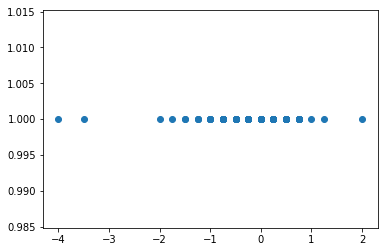

In [13]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_bias1_op = tf.assign(b1,
                          tf.round(b1/ROUNDING_STEP_BIAS)*ROUNDING_STEP_BIAS)
rounding_weights2_1_op = tf.assign(w2_1, 
                          tf.round(w2_1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_weights2_2_op = tf.assign(w2_2, 
                          tf.round(w2_2/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_weights2_3_op = tf.assign(w2_3, 
                          tf.round(w2_3/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_thresh_op = tf.assign(thresh,
                          tf.round(thresh/ROUNDING_STEP_BIAS)*ROUNDING_STEP_BIAS)
_ = sess.run([rounding_weights1_op, rounding_bias1_op])
_ = sess.run([rounding_weights2_1_op, rounding_weights2_2_op])
_ = sess.run([rounding_weights2_3_op, rounding_thresh_op])


# Show final distribution of weights
w1_values, b1_values = sess.run([w1, b1])
w2_1_values, w2_2_values = sess.run([w2_1, w2_2])
w2_3_values, thresh_values = sess.run([w2_3, thresh])

kernel_values = (list(w1_values.flatten()) + list(b1_values.flatten())
                 + list(w2_1_values.flatten())
                 + list(w2_2_values.flatten())
                 + list(w2_3_values.flatten())
                 + list(thresh_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))

test_accuracy_bin_rate(MAX_BIN_RATE)

## 3.4 Retrain FC: 94.9% with 3 bits weights, 96.9% when re-using the 4 bits weights with 3 bits quantisation only

In [0]:
LR = 0.001/4

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

opt_fc = tf.train.AdamOptimizer(learning_rate=LR, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
def test_accuracy_bin_rate(bin_rate_feed):
  accs = np.zeros(x_test.shape[0] // BATCH_SIZE)
  for i in range(x_test.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    
    xs = np.expand_dims(x_test[start:stop],-1) * INPUT_SCALING
    ys = y_test[start:stop]
    
    current_acc = sess.run(acc_op,
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed})
    accs[i] = current_acc
  
  print('Testing Acc.: {}'.format(
        accs.mean()))

In [19]:
bin_rate_feed = MAX_BIN_RATE + 1

for epoch in range(EPOCHS*2):

  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]

    xs = np.expand_dims(x_train[selected],-1) * INPUT_SCALING
    ys = y_train[selected]

    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss

  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

test_accuracy_bin_rate(MAX_BIN_RATE + 1)


Epoch 1 completed, average training loss is 0.09279116209130735
Testing Acc.: 0.9695000052452087
Epoch 2 completed, average training loss is 0.09228452049971869
Testing Acc.: 0.9679000067710877
Epoch 3 completed, average training loss is 0.09224487382142495
Testing Acc.: 0.969500008225441
Epoch 4 completed, average training loss is 0.09229470319890727
Testing Acc.: 0.969800009727478
Epoch 5 completed, average training loss is 0.09240733513142914
Testing Acc.: 0.9681000059843063
Epoch 6 completed, average training loss is 0.09212511174070338
Testing Acc.: 0.9697000080347061
Epoch 7 completed, average training loss is 0.0921264547482133
Testing Acc.: 0.9664000052213669
Epoch 8 completed, average training loss is 0.09226821243297309
Testing Acc.: 0.9689000076055527
Epoch 9 completed, average training loss is 0.09223237356403842
Testing Acc.: 0.9670000070333481
Epoch 10 completed, average training loss is 0.09257851402740926
Testing Acc.: 0.9691000074148178
Epoch 11 completed, average trai

In [20]:
test_accuracy_bin_rate(MAX_BIN_RATE)
test_accuracy_bin_rate(5000)

Testing Acc.: 0.9706000077724457
Testing Acc.: 0.9690000081062317


In [0]:
# Get final distribution of weights
w1_values, b1_values = sess.run([w1, b1])
w2_1_values, w2_2_values = sess.run([w2_1, w2_2])
w2_3_values, thresh_values = sess.run([w2_3, thresh])

with open('NP_KERNELS_WEIGHTS.pck', 'wb') as f:
  pickle.dump((w1_values, b1_values, w2_1_values, w2_2_values, w2_3_values, thresh_values), f)